In [213]:
import string
import unicodedata
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",None)



In [59]:
# import jsons
def json2dict(path):
    x = pd.read_json(path)
    return dict(zip(x['id'], x['name']))


pbooktitle = json2dict('data/pbooktitle.json')
pbooktitlefull = json2dict('data/pbooktitlefull.json')
pjournal = json2dict('data/pjournal.json')
pjournalfull = json2dict('data/pjournalfull.json')
ptype = json2dict('data/ptype.json')

# import csvs
dblp = pd.DataFrame()
for i in range(1, 5):
    csv = pd.read_csv(f'data/dblp-{i}.csv')
    dblp = pd.concat([dblp, csv]).reset_index(drop=True)

test_hidden = pd.read_csv('data/test_hidden.csv')
train = pd.read_csv('data/train.csv')
validation_hidden = pd.read_csv('data/validation_hidden.csv')

# Compare train/test/val keys to dblp.pkey
- All train.key1 & .key2 found in dblp.pkey -- True
- All val.key1 & .key2 found in dblp.pkey -- True
- All test.key1 & .key2 found in dblp.pkey -- True

Can assume pkey string correct, **CANNOT** assume belong to correct row


In [60]:
dblp_keys = dblp.pkey.tolist()
train_key1 = train.key1.tolist()
train_key2 = train.key2.tolist()
test_key1 = test_hidden.key1.tolist()
test_key2 = test_hidden.key2.tolist()
val_key1 = validation_hidden.key1.tolist()
val_key2 = validation_hidden.key2.tolist()

for key_str in ['train_key1', 'train_key2', 'test_key1', 'test_key2', 'val_key1', 'val_key2']:
    key_val = eval(key_str)
    diff = list(set(key_val).difference(dblp_keys))
    ndiff = len(diff)
    print(f"All {key_str} in pkey?: {ndiff==0}")



All train_key1 in pkey?: True
All train_key2 in pkey?: True
All test_key1 in pkey?: True
All test_key2 in pkey?: True
All val_key1 in pkey?: True
All val_key2 in pkey?: True


# Compare dblp.p<>_id keys and p<>.json keys
- pbooktitle_id == pbooktitlefull_id -- TRUE
- pbooktitle_id == pbooktitlefull_id -- TRUE
- All p<>.json keys found in dblp.p<>_id keys -- TRUE
- All pbooktitle_id and pjournal_id values found in p<>.json keys -- TRUE
- All pbooktitlefull_id and pjournalfull_id values in p<>.json keys -- FALSE
    - Not sure what to do about that

- pbooktitle_id == pbooktitlefull_id for all rows
- pjournal_id == pjournalfull_id for all rows
- All pbooktitle_id and pjournal_id values found in p<>.json keys
- Many full booktitles and journal values NOT found in p<>.json keys
- All p<>.json keys are found in dblp.p<>_id keys 

In [61]:
# are booktitle ids the same per row? 
bool_book = dblp['pbooktitle_id'].equals(dblp['pbooktitlefull_id'])
bool_journal = dblp['pjournal_id'].equals(dblp['pjournalfull_id'])
print(f'pbooktitle_id: {bool_book}')
print(f'pjournal_id: {bool_journal}')


pbooktitle_id: True
pjournal_id: True


In [62]:
# are there any p*_id values NOT found in their p*.json dictionary?
ids = ['ptype_id', 'pjournal_id', 'pjournalfull_id',
       'pbooktitle_id', 'pbooktitlefull_id']

for id in ids:
    d = eval(id[:-3])  # key_dict
    id_in_key = dblp[id].isin(d.keys())
    print(f"{id} NOT in key: {sum(~id_in_key)}")
    
    
bool_jfull = dblp['pjournalfull_id'].isin(pjournalfull.keys())
dblp[~bool_jfull].sample(5)


ptype_id NOT in key: 0
pjournal_id NOT in key: 0
pjournalfull_id NOT in key: 3518
pbooktitle_id NOT in key: 0
pbooktitlefull_id NOT in key: 3240


,Unnamed: 0,pauthor,peditor,ptitle,pyear,paddress,ppublisher,pseries,pid,pkey,ptype_id,pjournal_id,pbooktitle_id,pjournalfull_id,pbooktitlefull_id,partition
8329,8712,An interactive service customization model.,NaN,Jian Cao|Jie Wang|Kincho H. Law|Shen-sheng Zha...,2006,NaN,NaN,NaN,2046912,journals/infsof/CaoWLZL06,3,158,5,158,5,2
14456,7011,Peter Belobaba|András Farkas,NaN,Yield Management Impacts on Airline Spill Esti...,1999,NaN,NaN,NaN,2392338,journals/transci/BelobabaF99,2,496,5,496,5,4
10332,7815,G. J. Garvin|Milos Zefran|Ealan A. Henis|Vijay...,NaN,Two-arm trajectory planning in a manipulation ...,1997,NaN,NaN,NaN,1838463,journals/bc/GarvinZHK97,1,254,5,254,5,3
11575,3644,Ching-Wei Yeh,NaN,On the acceleration of flow-oriented circuit c...,1995,NaN,NaN,NaN,2233910,journals/tcad/Yeh95,3,220,0,220,0,3
14904,9070,William Pike|Joe Bruce|Bob Baddeley|Daniel Bes...,NaN,The Scalable Reasoning System: Lightweight vis...,-2009,NaN,NaN,NaN,2073844,journals/ivs/PikeBBBFMRRY09,3,474,2058,474,2058,4


In [63]:
# are all p*.json keys found in dblp.p*_id column?
for id in ids:
    d = eval(id[:-3])  # key_dict
    dblp_keys = dblp[id]
    dict_notin_dblp = np.setdiff1d(list(d.keys()), list(dblp_keys))
    print(f"{id[:-3]} keys NOT in {id}: {len(dict_notin_dblp)}")


ptype keys NOT in ptype_id: 0
pjournal keys NOT in pjournal_id: 0
pjournalfull keys NOT in pjournalfull_id: 0
pbooktitle keys NOT in pbooktitle_id: 0
pbooktitlefull keys NOT in pbooktitlefull_id: 0


# DBLP Inspection

## Are pyear values realistic?
- pyear values >0 -- FALSE
- pyear distribution realistic -- TRUE


<AxesSubplot:>

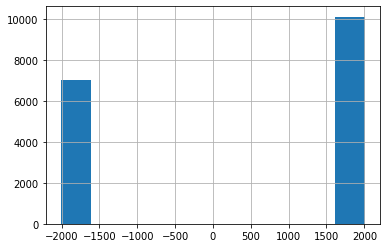

In [64]:
#pyear values < 0
dblp['pyear'].hist()


<AxesSubplot:>

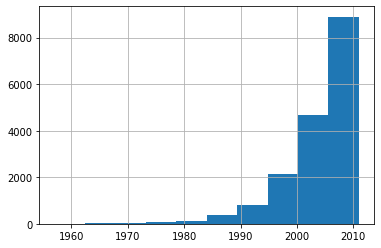

In [65]:
# what is the distribution of year values
dblp['pyear'].abs().hist()

## What is %NULL of peditor, paddress, ppublisher, pseries?
- peditor = 100% -- REMOVE
- paddress = 100% -- REMOVE
- ppublisher = 99.90% -- REMOVE?
- pseries = 99.97% -- REMOVE?

In [67]:
# percentage of null values
for col in ['peditor', 'paddress', 'ppublisher', 'pseries']:
    print(f'%Null {col}: {dblp[col].isna().sum()/dblp.shape[0]*100}%')


%Null peditor: 100.0%
%Null paddress: 100.0%
%Null ppublisher: 99.9009612583746%
%Null pseries: 99.97087095834547%


In [68]:
# view non-null pseries
dblp[dblp['pseries'].notna()].sort_values(by='pseries')


,Unnamed: 0,pauthor,peditor,ptitle,pyear,paddress,ppublisher,pseries,pid,pkey,ptype_id,pjournal_id,pbooktitle_id,pjournalfull_id,pbooktitlefull_id,partition
2129,9581,Willem P. de Roever|Frank S. de Boer|Ulrich Ha...,NaN,Concurrency Verification: Introduction to Comp...,2001,NaN,Cambridge University Press,Cambridge Tracts in Theoretical Computer Science,529,books/cu/RoeverBH2001,8,0,0,0,0,1
17153,9951,Akquisition von Integritätsbedingungen in Date...,NaN,Meike Klettke,-1998,NaN,"Infix Verlag, St. Augustin, Germany",DISDBIS,1772,books/infix/Klettke98,8,0,5,0,5,4
8671,376,Ravi R. Mazumdar,NaN,"Performance Modeling, Loss Networks, and Stati...",2009,NaN,Morgan & Claypool Publishers,Synthesis Lectures on Communication Networks,2434112,series/synthesis/2009Mazumdar,7,0,178,0,178,3
3884,7900,Sing Bing Kang|Long Quan,NaN,Image-Based Modeling of Plants and Trees,-2009,NaN,Morgan & Claypool Publishers,Synthesis Lectures on Computer Vision,2434225,series/synthesis/2009Kang,7,0,2615,0,2615,1
7847,6288,ChengXiang Zhai,NaN,Statistical Language Models for Information Re...,2008,NaN,Morgan & Claypool Publishers,Synthesis Lectures on Human Language Technologies,2434111,series/synthesis/2008Zhai,8,0,2530,0,2530,2


In [69]:
# view non-null ppublisher
dblp[dblp['ppublisher'].notna()].sort_values(by='ppublisher')


,Unnamed: 0,pauthor,peditor,ptitle,pyear,paddress,ppublisher,pseries,pid,pkey,ptype_id,pjournal_id,pbooktitle_id,pjournalfull_id,pbooktitlefull_id,partition
2129,9581,Willem P. de Roever|Frank S. de Boer|Ulrich Ha...,NaN,Concurrency Verification: Introduction to Comp...,2001,NaN,Cambridge University Press,Cambridge Tracts in Theoretical Computer Science,529,books/cu/RoeverBH2001,8,0,0,0,0,1
6270,8713,Thomas Ludwig,NaN,Algebraical Optimization of FTA-Expressions,-1988,NaN,IBM Deutschland GmbH,NaN,2420895,tr/ibm/LILOG59,3,209,5,209,5,2
538,2238,Thomas Ludwig,NaN,EFTA: An Algebra for Deductive Retrieval of Fe...,-1988,NaN,IBM Deutschland GmbH,NaN,2420894,tr/ibm/LILOG58,3,209,5,209,5,1
1838,8319,Michael Herweg|Mohammed Nadjib Khenkhar|Simone...,NaN,Elsaß-Wanderung für Linguisten: Exemplarische ...,-1988,NaN,IBM Deutschland GmbH,NaN,2420912,tr/ibm/LILOGM8,3,573,5,573,5,1
13164,1124,Thomas Ludwig,NaN,FLL: A First-Order Language for Deductive Retr...,-1988,NaN,IBM Deutschland GmbH,NaN,2420893,tr/ibm/LILOG57,3,209,5,209,5,4
13655,3238,Thomas Ludwig|Arne Pott,NaN,Rule Rewriting Techniken zur globalen Optimier...,-1989,NaN,"IBM Germany Science Center, Institute for Know...",NaN,2420703,tr/ibm/IWBS105,2,156,5,156,5,4
6540,9906,Reiner Hähnle|Bernhard Beckert|Stefan Gerberdi...,NaN,The Many-Valued Theorem Prover 3TAP.,-1992,NaN,"IBM Germany Science Center, Institute for Know...",NaN,2420788,tr/ibm/IWBS227,3,156,5,156,5,2
14207,5862,Thomas Ludwig,NaN,A Brief Overlook of LILOG-DB,-1989,NaN,"IBM Germany Science Center, Institute for Know...",NaN,2420697,tr/ibm/IWBS102,3,156,5,156,5,4
182,751,Thomas Ludwig,NaN,Modeling Structured Open Worlds in a Database ...,-1991,NaN,"IBM Germany Science Center, Institute for Know...",NaN,2420785,tr/ibm/IWBS149,0,156,5,156,5,1
4580,1200,Thomas Ludwig,NaN,The Design and Implementation of TLPROLOG (V. ...,1989,NaN,"IBM Germany Science Center, Institute for Know...",NaN,2420699,tr/ibm/IWBS103,3,156,5,156,5,2


## Unsure what dblp.pid represents -- no duplicates


In [ ]:
dblp[ dblp['pid'].duplicated(keep=False) ]

## dblp.unnamed_0 represents pkey pairs to compared in train, val, or testing


In [80]:
print(dblp[dblp['Unnamed: 0']==9999]['pkey'])

print(train[train['Unnamed: 0']==9999][['key1','key2']])

2232     journals/ijcv/DavidDDS04
12908        conf/eccv/DavidDDS02
Name: pkey, dtype: object
                          key1                  key2
7971  journals/ijcv/DavidDDS04  conf/eccv/DavidDDS02


## Different languages + accents present
- ptitle and pauthor contain 139 unique characters
- possible to remove accents without distorting characters
- proposed function does not handle for ×, Ø, ß, or æ

In [226]:
# example of accents
pjournalfull.get(88)


'Revista de Informática Teórica e Aplicada - RITA'

In [227]:
# example of other language
dblp[ dblp['ptitle'].str.contains(r'ß') ]


,Unnamed: 0,pauthor,peditor,ptitle,pyear,paddress,ppublisher,pseries,pid,pkey,ptype_id,pjournal_id,pbooktitle_id,pjournalfull_id,pbooktitlefull_id,partition
1129,4861,Thomas Gehrke,NaN,Zum Einsatz einer graphischen Entwurfsmethode ...,-1997,NaN,NaN,NaN,236886,conf/fbt/Gehrke97,4,0,504,0,504,1
1838,8319,Michael Herweg|Mohammed Nadjib Khenkhar|Simone...,NaN,Elsaß-Wanderung für Linguisten: Exemplarische ...,-1988,NaN,IBM Deutschland GmbH,NaN,2420912,tr/ibm/LILOGM8,3,573,5,573,5,1
2635,1769,Martin Bertram 0002,NaN,Anwendungsbeispiel der Anbindung eines PC-LAN'...,-1989,NaN,NaN,NaN,268377,conf/gi/Bertram89,1,0,663,0,663,1
4892,2627,Marc Ebner,NaN,Lokale Beleuchtungsschätzung und Farbkorrektur...,2008,NaN,NaN,NaN,2141815,journals/ki/Ebner08,0,105,5,105,5,2
5239,4069,Younchan Jung|J. William Atwood,NaN,ß-Adaptive Playout Scheme for Voice over IP Ap...,2005,NaN,NaN,NaN,2011622,journals/ieicet/JungA05,3,34,5,34,5,2
5556,5439,Clinical evaluation of an operation planning s...,NaN,Jakob Brief|Stefan Haßfeld|C. Haag|Jan München...,2001,NaN,NaN,NaN,89328,conf/cars/BriefHHMSDEKTWM01,1,0,423,0,423,2
5590,5618,Reinhart D. Kühne,NaN,Makroskopische Verkehrssimulation zur Bewertun...,1997,NaN,NaN,NaN,707418,conf/simvis/Kuhne97,4,0,169,0,169,2
9103,2206,Peter Wagner|Martin Schneider,NaN,Verarbeitung großer Datenmengen mittels Neuron...,2007,NaN,NaN,NaN,272620,conf/gil/WagnerS07,1,0,790,0,790,3
9904,5686,Elektronische Interaktion in großen Lehrverans...,NaN,Chin-Man Choi|Henning Bär|Guido Rößling|Max Mü...,-2004,NaN,NaN,NaN,268595,conf/gi/ChoiBRM04,1,0,717,0,717,3
11119,1433,N. Model|Peter Rudolph|P. Lasch|K. Bellmann,NaN,Mehrkriterielle Sanierungsstrategien für Fluß-...,-1990,NaN,NaN,NaN,193048,conf/ebernburg/ModelRLB90,2,0,559,0,559,3


In [267]:
# what are the unique characters in the author/title
uniq = list(set(' '.join(dblp['ptitle']))) # ptitle
uniq += list(set(' '.join(dblp['pauthor']))) # pauthor

uniq_chars = pd.DataFrame(columns=['char'])
uniq_chars['char'] = np.unique( np.array(uniq) )
uniq_chars['lower_case'] = uniq_chars['char'].str.lower()

## remove accents
def remove_accents(s):
    '''
    https://docs.python.org/3/library/unicodedata.html#module-unicodedata
    '''
    s = str(s)      # cannot assume string
    norm_form = unicodedata.normalize('NFKD', s)
    return "".join([char for char in norm_form if not unicodedata.combining(char)])

uniq_chars['remove_accents'] = uniq_chars['char'].apply(remove_accents)

is_alnum = uniq_chars['char'].str.contains(r'[0-9a-zA-Z]')
bool_notChanged = uniq_chars['char'] == uniq_chars['remove_accents']
uniq_chars[ (is_alnum == False) & bool_notChanged ].T



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,25,26,27,28,29,30,57,58,59,60,61,62,89,90,91,92,93,94,96,108,109,111,118,134
char,,!,"""",#,$,&,',(,),*,+,",",-,.,/,:,;,=,>,?,@,[,\,],^,_,`,{,|,},,«,®,»,×,Ø,ß,æ,ø
lower_case,,!,"""",#,$,&,',(,),*,+,",",-,.,/,:,;,=,>,?,@,[,\,],^,_,`,{,|,},,«,®,»,×,ø,ß,æ,ø
remove_accents,,!,"""",#,$,&,',(,),*,+,",",-,.,/,:,;,=,>,?,@,[,\,],^,_,`,{,|,},,«,®,»,×,Ø,ß,æ,ø


## Inspect dblp.pauthor
- "|" indicates multiple authors
    - Could not find other symbols that would separate authors
- Many instances where pauthor-ptitle are switched
    - `ptitle.contains("|")` could identify switched values (only mult. authors)
    - `pauthor.endswith(".")` could identify switched values
    - pkey contains author name -- could compare overlapping strings
        - `pkey` = <>/<>/<>/<author>


In [147]:
# "|" indicates multiple authors
dblp[dblp['pauthor'].str.contains(r'[|]')].sample(5)


,Unnamed: 0,pauthor,peditor,ptitle,pyear,paddress,ppublisher,pseries,pid,pkey,ptype_id,pjournal_id,pbooktitle_id,pjournalfull_id,pbooktitlefull_id,partition
13024,445,Frank Emmert-Streib|Andre Ribeiro,NaN,Optimize Observational Time Points to Maximize...,-2008,NaN,NaN,NaN,76743,conf/biocomp/Emmert-StreibR08,1,0,37,0,37,4
2680,1984,M. R. Kermani|Rajnikant V. Patel|Mehrdad Moallem,NaN,A High Authority Piezoelectric Stack Actuator ...,2005,NaN,NaN,NaN,421639,conf/icra/KermaniPM05,1,0,102,0,102,1
15013,9625,Vicki W. H. Lee|Eric W. M. Wong,NaN,A New Incentive Charging Scheme for Hybrid Mul...,2006,NaN,NaN,NaN,2011074,journals/ieicet/LeeW06a,3,34,5,34,5,4
5914,7037,S. Q. Xie|X. Xu,NaN,A STEP-compliant process planning system for s...,2006,NaN,NaN,NaN,2375606,journals/ijcim/XieX06,0,287,0,287,0,2
11248,1977,Elvira Albert|Samir Genaim|Miguel Gómez-Zamalloa,NaN,Parametric inference of memory requirements fo...,-2010,NaN,NaN,NaN,546079,conf/iwmm/AlbertGG10,1,0,5,0,5,3


In [148]:
# test other symbols that would separate authors
dblp[dblp['pauthor'].str.contains(r'[;]')].head()
dblp[dblp['pauthor'].str.contains(r'[/]')].head()
dblp[dblp['pauthor'].str.contains(r'[\\]')].head()
dblp[dblp['pauthor'].str.contains(r'[*]')].head()
dblp[dblp['pauthor'].str.contains(r'[-]')].head()
dblp[dblp['pauthor'].str.contains(r'[:]')].head()


,Unnamed: 0,pauthor,peditor,ptitle,pyear,paddress,ppublisher,pseries,pid,pkey,ptype_id,pjournal_id,pbooktitle_id,pjournalfull_id,pbooktitlefull_id,partition
25,95,JavaCHIME: Java class hierarchy inspector and ...,NaN,Pallavi Tadepalli|H. Conrad Cunningham,2004,NaN,NaN,NaN,7300,conf/ACMse/TadepalliC04,1,0,41,0,41,1
48,206,Integrating Medical and Genomic Data: a Sucess...,NaN,Gaspar S. Dias|José Luís Oliveira|Javier Vicen...,2006,NaN,NaN,NaN,886649,conf/mie/DiasOVM06,1,0,98,0,98,1
80,371,Style Consistency and Authorship Attribution: ...,NaN,M. Bagavandas|G. Manimannan,-2008,NaN,NaN,NaN,2123214,journals/jql/BagavandasM08,2,92,175,92,175,1
98,449,Where would you bring your laptop?: live blogg...,NaN,Stina Nylander,2008,NaN,NaN,NaN,840243,conf/mum/Nylander08,1,0,207,0,207,1
114,524,The myGrid ontology: bioinformatics service di...,NaN,Katy Wolstencroft|Pinar Alper|Duncan Hull|Chri...,2007,NaN,NaN,NaN,2341039,journals/ijbra/WolstencroftAHWLSG07,3,130,5,130,5,1


In [ ]:
# pauthor-ptitle switched for many documents
dblp.loc[[17160]]


,Unnamed: 0,pauthor,peditor,ptitle,pyear,paddress,ppublisher,pseries,pid,pkey,ptype_id,pjournal_id,pbooktitle_id,pjournalfull_id,pbooktitlefull_id,partition
17160,9975,Online bin packing with arbitrary release times.,NaN,Yongqiang Shi|Deshi Ye,2008,NaN,NaN,NaN,2245299,journals/tcs/ShiY08,0,12,5,12,5,4


In [149]:
# ending punctuation may indicate if pauthor-ptitle are switched"
dblp[dblp['pauthor'].str.endswith(r',')] # n=0
dblp[dblp['pauthor'].str.endswith(r'!')] # n=0
dblp[dblp['pauthor'].str.endswith(r'?')] # n=12
dblp[dblp['pauthor'].str.endswith(r'.')] # n=3006


,Unnamed: 0,pauthor,peditor,ptitle,pyear,paddress,ppublisher,pseries,pid,pkey,ptype_id,pjournal_id,pbooktitle_id,pjournalfull_id,pbooktitlefull_id,partition
6,22,A fourth-order compact difference scheme on fa...,NaN,Haiwei Sun|Ning Kang|Jun Zhang|Eric S. Carlson,-2003,NaN,NaN,NaN,2324621,journals/mcs/SunKZC03,3,6,5,6,5,1
16,65,Modèles d'Ordonnancement pour l'Annotation Aut...,NaN,Ludovic Denoyer|Patrick Gallinari,2010,NaN,NaN,NaN,137175,conf/coria/DenoyerG10,1,0,28,0,28,1
18,68,Performance analysis of single-slave Bluetooth...,NaN,Daniel Cascado Caballero|José Luis Sevillano|S...,2004,NaN,NaN,NaN,879807,conf/pimrc/CaballeroSVRJLB04,0,0,30,0,30,1
23,89,Coherence Resonance in a Fitzhugh-nagumo Elect...,NaN,Stefano Brugioni|Dong Uk Hwang|Riccardo Meucci...,-2007,NaN,NaN,NaN,2382759,journals/ijbc/BrugioniHMB07,3,31,0,31,0,1
25,95,JavaCHIME: Java class hierarchy inspector and ...,NaN,Pallavi Tadepalli|H. Conrad Cunningham,2004,NaN,NaN,NaN,7300,conf/ACMse/TadepalliC04,1,0,41,0,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17148,9934,Query Answering by Means of Diagram Transforma...,NaN,Jaume Agustí-Cullell|Jordi Puigsegur|W. Marco ...,1998,NaN,NaN,NaN,252561,conf/fqas/AgustiPS98,1,0,739,0,739,4
17149,9936,Using Meta-reasoning to Improve the Performanc...,NaN,Manish Mehta|Santiago Ontañón|Ashwin Ram,2009,NaN,NaN,NaN,334039,conf/iccbr/MehtaOR09,1,0,679,0,679,4
17153,9951,Akquisition von Integritätsbedingungen in Date...,NaN,Meike Klettke,-1998,NaN,"Infix Verlag, St. Augustin, Germany",DISDBIS,1772,books/infix/Klettke98,8,0,5,0,5,4
17156,9965,An analytical model for evaluating utilization...,NaN,Mohammad Mehdi Hassani|Reza Berangi,-2007,NaN,NaN,NaN,849614,conf/compsystech/HassaniB07a,1,0,2719,0,2719,4


In [220]:
# pauthor substring should match name in pkey
x = dblp.copy()

def process_str(s, key=False):
    s = str(s)
    s = s.lower()
    s = s.replace('\\', r'\\')
    s = remove_accents(s)
    s = s.strip()  # remove leading/trailing white space
    
    if key == True:
        return s.split(r'/')[-1]

    s = re.sub(r'['+string.punctuation+']', ' ', s)
    s = s.split()  # split by white space

    return s


# def compare_str_overlap(col_str, pkey):
#     '''
#     process and compare pauthor & ptitle with pkey author
#     '''
    
#     col = process_str(col_str)  # list of individual words
#     key = process_str(pkey, key=True)   # pkey[-1] str segment
#     max_overlap = 0
#     top_str = ''
    
#     for substr in col:
#         if re.findall(substr, key):
#             overlap = re.findall(substr, key)[0]
#             if len(overlap) > max_overlap:
#                 top_str = substr
#                 max_overlap = len(overlap)
   
#     return (top_str, key, max_overlap)

# x['pauthor_pkey'] = x.apply(lambda x: compare_str_overlap(x['pauthor'], x['pkey']), axis=1)


def compare_str_overlap(pauthor, ptitle, pkey):
    '''
    process and compare pauthor and ptitle to pkey
    
    return bool -- True if ptitle more overlap than pauthor
    '''

    pauthor = process_str(pauthor, key=False)
    ptitle = process_str(ptitle, key=False)
    pkey = process_str(pkey, key=True)

    max_titleOverlap = max([len(re.findall(substr, pkey)[0])
                           for substr in ptitle
                           if re.findall(substr, pkey)])

    max_authorOverlap = max([len(re.findall(substr, pkey)[0])
                             for substr in pauthor
                             if re.findall(substr, pkey)])

    return max_titleOverlap > max_authorOverlap




## pid has no duplicated values
- Unsure what the column represents
- Should we remove? 

In [4]:
dblp[ dblp['pid'].duplicated(keep=False) ]

,Unnamed: 0,pauthor,peditor,ptitle,pyear,paddress,ppublisher,pseries,pid,pkey,ptype_id,pjournal_id,pbooktitle_id,pjournalfull_id,pbooktitlefull_id,partition


## partition = dblp-{i}.csv 
- train, test_hidden, and validation_hidden have partition column

In [9]:
dblp['partition'].unique()

array([1, 2, 3, 4])